In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import wandb
wandb.init(project="mountain-car-dqn")

W&B Run: https://app.wandb.ai/rauf-kurbanov/mountain-car-dqn/runs/lwa0qtaa

In [4]:
device = torch.device("cuda")

DQNs tend to “forget” certain $(s,a)=r$ situations it encountered in the past (kinda like catastrophic forgetting).

Whole __experience replay__ idead is tp maintain a buffer of the old experiences and train it again on them.

In [5]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity, device=torch.device("cpu")):
        self.buffer = deque(maxlen=capacity)
        self.device = device
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
        
    def __len__(self):
        return len(self.buffer)

<h2>Mountain Car Environment</h2>

A car is on a one-dimensional track, positioned between two "mountains".<br>
The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass.<br>
Therefore, the only way to succeed is to drive back and forth to build up momentum.

In [6]:
from IPython.display import HTML

HTML("""
    <video alt="car" controls>
        <source src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCar-v0/original.mp4" type="video/mp4">
    </video>
""")

In [7]:
env_id = "MountainCar-v0"
env = gym.make(env_id)

<h2>Epsilon greedy exploration</h2>

Greedy and Epsilon Greedy exploration methods are fairly easy to understand and to implement, but they suffer from major setback which is they have sub-optimal regret. As a matter of fact the regret of both Greedy and Epsilon Greedy grows linearly by the time.

This is easy to intuitively understand, as the Greedy will lock on one action that happened to have good results at one point of time but it is not in reality the optimal action. So Greedy will keep exploiting this action while ignoring the others which might be better. It Exploits too much.

The Epsilon Greedy on the other hand, explores too much because even when one action seem to be the optimal one, the methods keeps allocating a fixed percentage of the time for exploration.

Conversely the decaying Epsilon Greedy methods, tries to decrease the percentage dedicated for exploration as time goes by.<br>
Exploration probability is shown in the graph below.

In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

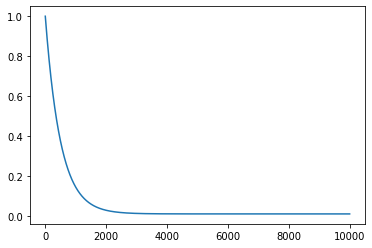

In [9]:
plt.plot([epsilon_by_frame(i) for i in range(10000)]);

<h2>Deep Q Network</h2>

DQN is a convolutional neural network, trained with a variant of Q-learning. It was first applied to seven Atari 2600 games from the Arcade Learning Environment, with no adjustment of the architecture or learning algorithm.

For more info we suggest readinf the paper https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning

In [10]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [11]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
model = model.to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(capacity=1000)

<h2>Computing Temporal Difference Loss</h2>

In [12]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [13]:
def plot(frame_idx, rewards, losses, env):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('environment')
    plt.imshow(env.render(mode='rgb_array'))

    plt.show()

<h2>Training</h2>

In [14]:
state = env.reset()

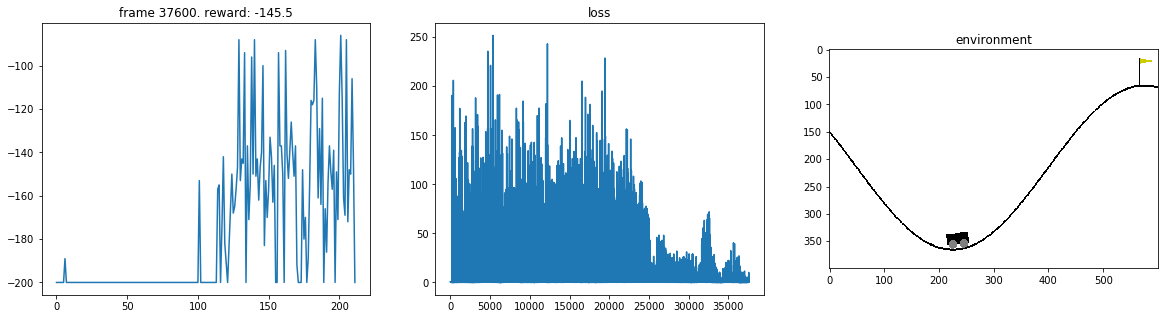

In [ ]:
num_frames = 100000
batch_size = 32
gamma      = 0.99
plot_every = 200

losses = []
all_rewards = []
episode_reward = 0

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    if isinstance(action, torch.Tensor):
        action = action.item()
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state 
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        wandb.log({'reward': episode_reward, 'loss': loss.data.item(),
                  'environment': wandb.Image(env.render(mode='rgb_array'))})
        losses.append(loss.data.item())
    
    if frame_idx % plot_every == 0:
        plot(frame_idx, all_rewards, losses, env)